In [64]:
import numpy as np
import pandas as pd
import tqdm
import re
from lightfm import LightFM
from tqdm import tqdm

from itertools import combinations

from io import BytesIO
from PIL import Image
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import gensim
from scipy.sparse import coo_matrix, csr_matrix
from scipy.sparse.linalg import svds

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import warnings
warnings.simplefilter('ignore')

%matplotlib inline

sns.set(style="darkgrid")

In [38]:
books = pd.read_csv('BX-Books.csv')
interactions = pd.read_csv('BX-Book-Ratings.csv', sep=';', encoding = 'ISO-8859-1')
interactions = interactions[interactions["Book-Rating"] != 0]

In [125]:
interactions.head()

User-ID        ISBN  Book-Rating  user_num  books_num  \
0   276822  0060096195           10        53         15   
1   276822  0375821813            9        10         15   
2   276822  0786817070           10        74         15   
3   276847  3404148576            8        10         36   
4   276847  3423071516           10        13         36   

                                         picture_url  \
0  http://images.amazon.com/images/P/0060096195.0...   
1  http://images.amazon.com/images/P/0375821813.0...   
2  http://images.amazon.com/images/P/0786817070.0...   
3  http://images.amazon.com/images/P/3404148576.0...   
4  http://images.amazon.com/images/P/3423071516.0...   

                            Book-Title  product_id    vid  cluster  
0                    The Boy Next Door          98  10883      287  
1            Hoot (Newbery Honor Book)        2737  10883      287  
2  Artemis Fowl (Artemis Fowl, Book 1)        8884  10883      287  
3                           Nordermoor       10402  10884      618  
4                    Der Kleine Hobbit       10409  10884      618

In [41]:
books_meets = interactions.groupby('ISBN')['User-ID'].count().reset_index().rename(columns={'User-ID': 'user_num'})
user_meets = interactions.groupby('User-ID')['ISBN'].count().reset_index().rename(columns={'ISBN': 'books_num'})

In [42]:
interactions = interactions.merge(books_meets, on=['ISBN']).merge(user_meets, on=['User-ID'])

In [43]:
interactions = interactions[(interactions['user_num'] > 5) & 
                            (interactions['books_num'] > 5) &
                            (interactions['books_num'] < 200)]

In [44]:
users = pd.read_csv('BX-Users.csv', delimiter=';', encoding='ISO-8859-1')

In [45]:
interactions = interactions.merge(books[['ISBN', 'Image-URL-M', 'Book-Title']].rename(
    columns={'Image-URL-M': 'picture_url'}), on=['ISBN'])

In [46]:
le = preprocessing.LabelEncoder()

interactions['product_id'] = le.fit_transform(interactions['ISBN'])
interactions['vid'] = le.fit_transform(interactions['User-ID'])

In [47]:
csr_rates = coo_matrix((interactions['Book-Rating'], (interactions['vid'], interactions['product_id'])), 
                            shape=(len(set(interactions['vid'])), len(set(interactions['product_id']))))

In [48]:
for i, j in interactions[['product_id', 'Book-Title']].drop_duplicates().values:
    if 'David Copperfield' in j:
        print('idx:', i, '\tBook Title:', j)

idx: 1074 	Book Title: David Copperfield (Penguin Classics)
idx: 10174 	Book Title: David Copperfield (Wordsworth Classics)


# персональный топ 

Посмотрим сначала на распределение значений age.

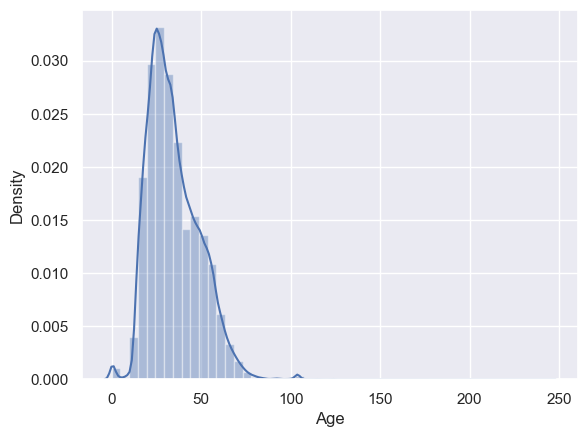

In [49]:
sns.distplot(users['Age']);

Судя по гистограмме, у нас есть люди с нетипично большим возрастом. Это ошибки данных, необходимо избавиться от них.

In [50]:
users = users.loc[(users.Age >= 5) & (users.Age <= 95)]

In [51]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

def rec_imaging(product_ids, content_dict, measure=None, top_n=5):
    picture_urls = [content_dict[i] for i in product_ids]
    cnt = 0
    for idx, chunk in enumerate(chunks(picture_urls, top_n)):
        fig = plt.figure(figsize=(20, 4))
        for n, i in enumerate(chunk):
            try:
                headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/16.5 Safari/605.1.15', 'Accept-Encoding': 'gzip, deflate, br', 'Accept': '*/*', 'Connection': 'keep-alive'}
                r = requests.get(i, headers=headers)
                im = Image.open(BytesIO(r.content))

            except:
                print('Something went wrong with {url}'.format(url=i))
                continue

            a = fig.add_subplot(1, top_n, n + 1)
            if measure is not None:
                a.title.set_text("measure = {}".format(np.round(measure[cnt], 4)))
                cnt += 1
            plt.imshow(im)
            plt.axis('off')
        plt.show()

In [52]:
users.head()

User-ID                        Location   Age
1         2       stockton, california, usa  18.0
3         4       porto, v.n.gaia, portugal  17.0
5         6   santa monica, california, usa  61.0
9        10      albacete, wisconsin, spain  26.0
10       11  melbourne, victoria, australia  14.0

In [53]:
def get_personal_top(age, location, top_n=5):
    book_id_to_url = {}
    for i in interactions[['product_id', 'picture_url']].values:
        book_id_to_url[i[0]] = i[1]
    
    user_subset = users[(users['Age'] < age + 6) & 
                        (users['Location'].apply(lambda x: x.split(',')[-1].lower().strip() == location)) &
                        (users['Age'] > age - 6)]
    
    segment = interactions[interactions['User-ID'].isin(user_subset['User-ID'])]
    book_ratings = segment.groupby('product_id')['Book-Rating'].mean().reset_index()
    top_books = book_ratings.sort_values(by='Book-Rating', ascending=False)[:top_n]

    rec_imaging(top_books['product_id'].values, book_id_to_url)

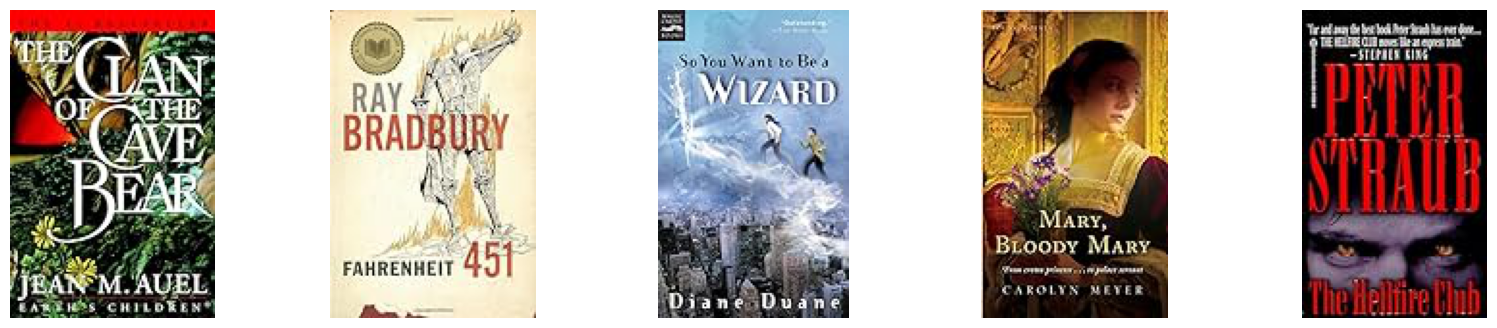

In [54]:
get_personal_top(40, 'usa')

# рекомендации на основе метода кластеризации похожих пользователей

100%|███████████████████████████████████████████| 10/10 [01:09<00:00,  6.96s/it]


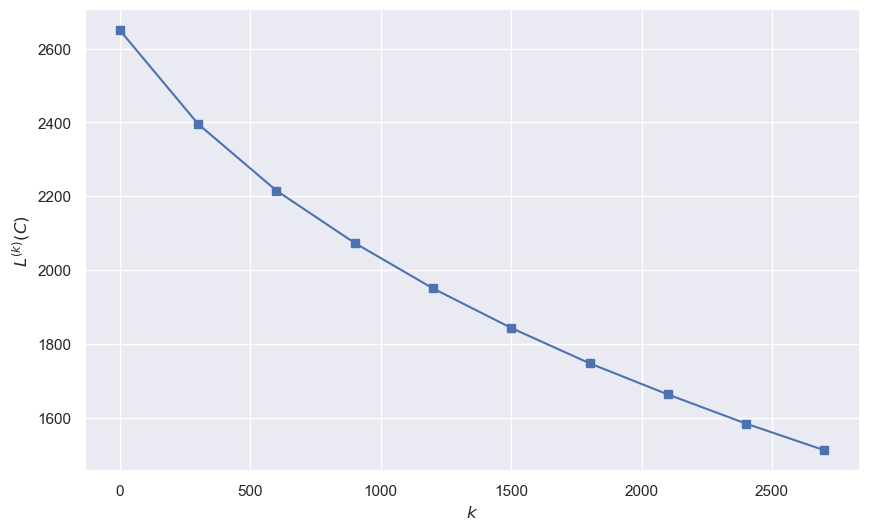

In [57]:
def elbow(train, k_range, random_state):
    crit = []

    for k in tqdm(k_range):
        kmeans = KMeans(n_clusters=k, random_state=random_state, n_init='auto').fit(train)
        crit.append(np.sqrt(kmeans.inertia_))

    plt.figure(figsize=(10, 6))
    plt.plot(k_range, crit, marker='s')
    plt.xlabel('$k$')
    plt.ylabel('$L^{(k)}(C)$')
    plt.show()

elbow(csr_rates, range(1, 3000, 300), 42)

In [58]:
kmeans = KMeans(n_clusters=700, random_state=42) 
clusters = kmeans.fit_predict(csr_rates)

In [59]:
clustered_users = pd.DataFrame({'vid': list(set(interactions['vid'])), 'cluster': clusters})

In [60]:
interactions = interactions.merge(clustered_users, on='vid', how='left')
interactions.head()

User-ID        ISBN  Book-Rating  user_num  books_num  \
0   276822  0060096195           10        53         15   
1   276822  0375821813            9        10         15   
2   276822  0786817070           10        74         15   
3   276847  3404148576            8        10         36   
4   276847  3423071516           10        13         36   

                                         picture_url  \
0  http://images.amazon.com/images/P/0060096195.0...   
1  http://images.amazon.com/images/P/0375821813.0...   
2  http://images.amazon.com/images/P/0786817070.0...   
3  http://images.amazon.com/images/P/3404148576.0...   
4  http://images.amazon.com/images/P/3423071516.0...   

                            Book-Title  product_id    vid  cluster  
0                    The Boy Next Door          98  10883      287  
1            Hoot (Newbery Honor Book)        2737  10883      287  
2  Artemis Fowl (Artemis Fowl, Book 1)        8884  10883      287  
3                           Nordermoor       10402  10884      618  
4                    Der Kleine Hobbit       10409  10884      618

In [120]:
def get_top_books_clustering(user_id):
    book_id_to_url = {}
    for i in interactions[['product_id', 'picture_url']].values:
        book_id_to_url[i[0]] = i[1]
    
    cluster_id = interactions[interactions['vid'] == user_id]['cluster'].values[0] 

    cluster_users = interactions[interactions['cluster'] == cluster_id]['vid']
    
    cluster_ratings = interactions[interactions['vid'].isin(cluster_users)]
    
    avg_ratings = cluster_ratings.groupby('product_id')['Book-Rating'].mean().reset_index()
    avg_ratings = avg_ratings.rename(columns={'Book-Rating': 'average_rating'})

    top_books = avg_ratings.sort_values(by='average_rating', ascending=False).head(10)

    rec_imaging(top_books['product_id'].values, book_id_to_url)

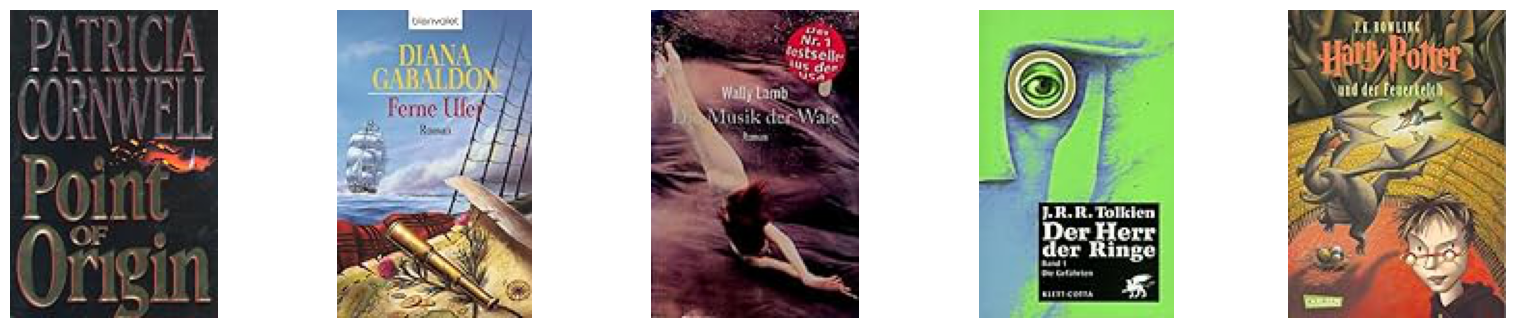

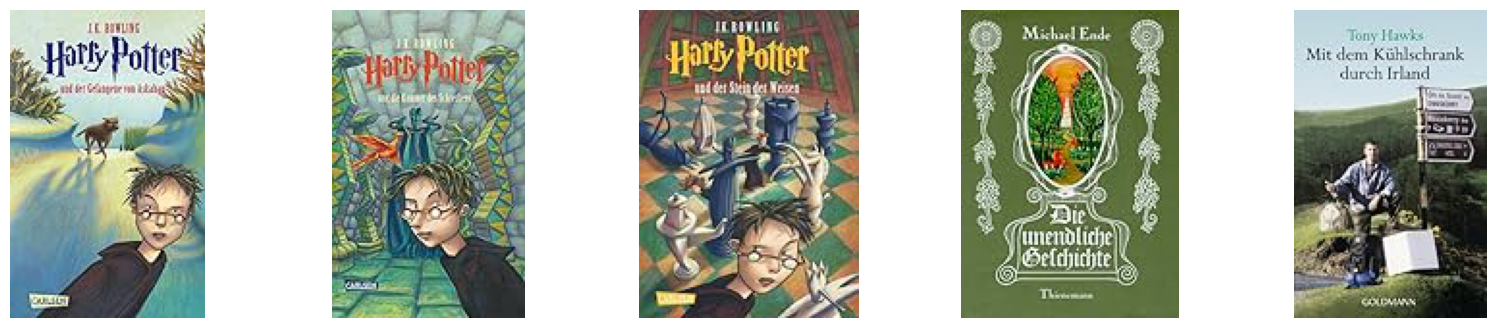

In [121]:
get_top_books_clustering(10884)

# Совстречаемость

In [63]:
def calculate_pair_weight(rating1, rating2):
    return (rating1 + rating2) / 2

In [76]:
user_groups = interactions.groupby('vid')
for user, group in user_groups:
    p = combinations(group[['product_id', 'Book-Rating']].values, 2)
list(p)

[(array([2647,    7]), array([4019,    7])),
 (array([2647,    7]), array([6880,    8])),
 (array([4019,    7]), array([6880,    8]))]

In [83]:
user_groups = interactions.groupby('vid')

pair_weights = []

for user, group in user_groups:
    pairs = combinations(group[['product_id', 'Book-Rating']].values, 2)
    for (book1, rating1), (book2, rating2) in pairs:
        weight = calculate_pair_weight(rating1, rating2)
        pair_weights.append({'first_book': book1, 'second_book': book2, 'weight': weight})

In [145]:
pair_weights = pd.DataFrame(pair_weights)
pair_weights_grouped = pair_weights.groupby(['first_book', 'second_book']).agg({'weight': 'sum'}).reset_index()

In [146]:
book_ids = list(set(pair_weights['first_book']).union(set(pair_weights['second_book'])))
co_occurrence_matrix = pd.DataFrame(data=np.zeros((len(book_ids), len(book_ids))), index=book_ids, columns=book_ids)

In [147]:
for _, row in tqdm(pair_weights.iterrows()):
    co_occurrence_matrix.loc[row['first_book'], row['second_book']] = row['weight']
    co_occurrence_matrix.loc[row['second_book'], row['first_book']] = row['weight']

1455297it [04:49, 5034.36it/s]


In [150]:
def recommend_books_i2i(book_id, co_occurrence_matrix, num_recommendations=10):
    book_id_to_url = {}
    for i in interactions[['product_id', 'picture_url']].values:
        book_id_to_url[i[0]] = i[1]
        
    similar_books = co_occurrence_matrix.loc[book_id]
    
    similar_books_sorted = sorted(similar_books.items(), key=lambda x: x[1], reverse=True)
    
    recommended_books = [book for book, _ in similar_books_sorted[:num_recommendations]]

    rec_imaging(recommended_books, book_id_to_url)

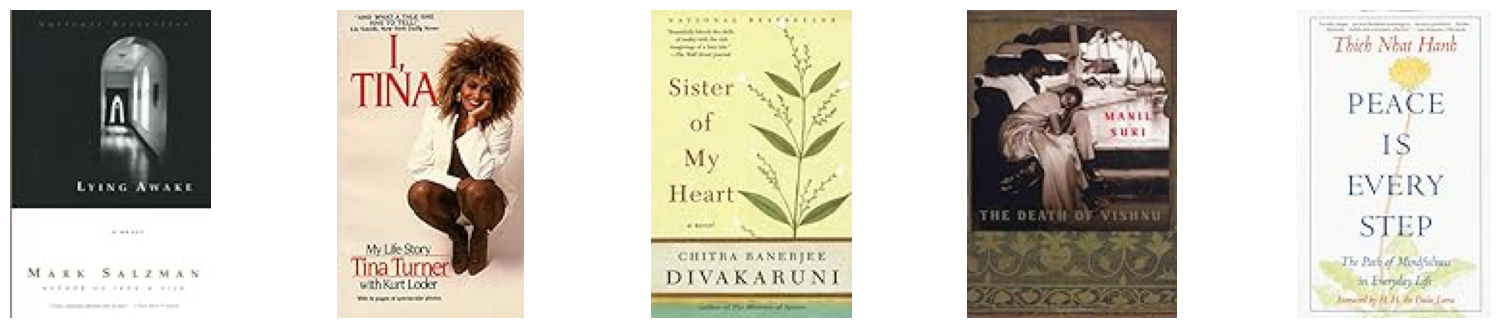

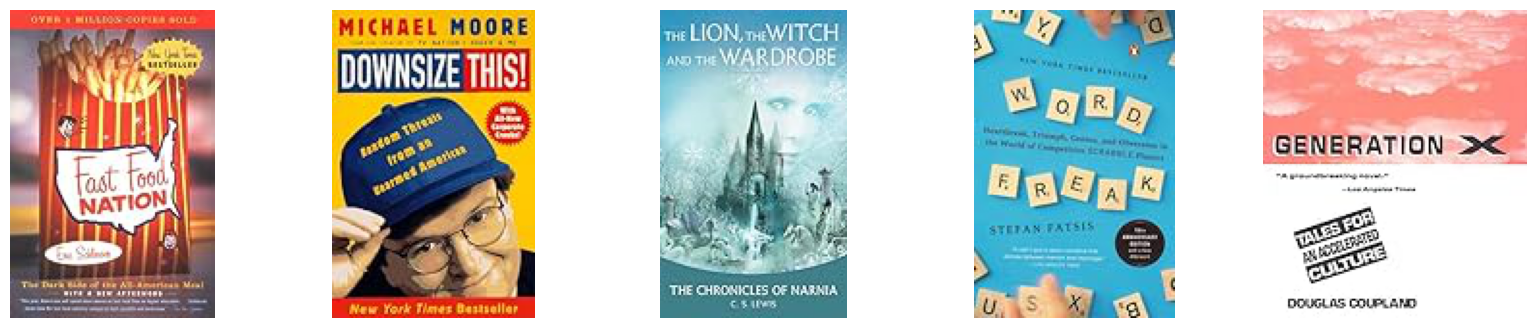

In [176]:
recommend_books_i2i(650, co_occurrence_matrix, 10)

# Коллаборативная фильтрация

In [172]:
class Colloborative:
    def __init__(self, interactions):
        self.content_dict = {}
        for i, j in interactions[['product_id', 'picture_url']].drop_duplicates().values:
            self.content_dict[int(i)] = j
        self.csr_rates = coo_matrix((interactions['Book-Rating'], (interactions['vid'], interactions['product_id'])),
                                  shape=(len(set(interactions['vid'])), len(set(interactions['product_id']))))
        

    def user_based(self, user_id):
        user_rates = self.csr_rates.getrow(user_id).toarray()[0]
        watched_items = np.where(user_rates != 0)[0]
        metrics = cosine_similarity([user_rates], self.csr_rates).reshape(-1, 1)
        rates = csr_matrix.multiply(self.csr_rates.copy(), metrics)
        total_rate = np.array(np.sum(rates, axis=0))[0]
        self.get_rec(watched_items, np.arange(self.csr_rates.shape[1])[np.argsort(total_rate)[::-1][:10]],
                    np.sort(total_rate)[::-1][:10])
        
    def item_based(self, item_id):
        item_rates = self.csr_rates.getcol(item_id).toarray().reshape(1, -1)
        metrics = cosine_similarity(item_rates, self.csr_rates.T).reshape(-1, 1)
        rates = csr_matrix.multiply(self.csr_rates.T.copy(), metrics)
        total_rate = np.array(np.sum(rates, axis=1)).ravel()
        self.get_rec([item_id], np.arange(self.csr_rates.shape[1])[np.argsort(total_rate)[::-1][:10]],
                    np.sort(total_rate)[::-1][:10])

    def get_rec(self, watched, recs, measure):
        print('Для таких товаров')
        rec_imaging([i for i in watched], self.content_dict)
        print('Такие рекомендации')
        rec_imaging([i for i in recs], self.content_dict, measure)

In [173]:
clb = Colloborative(interactions)

Для таких товаров


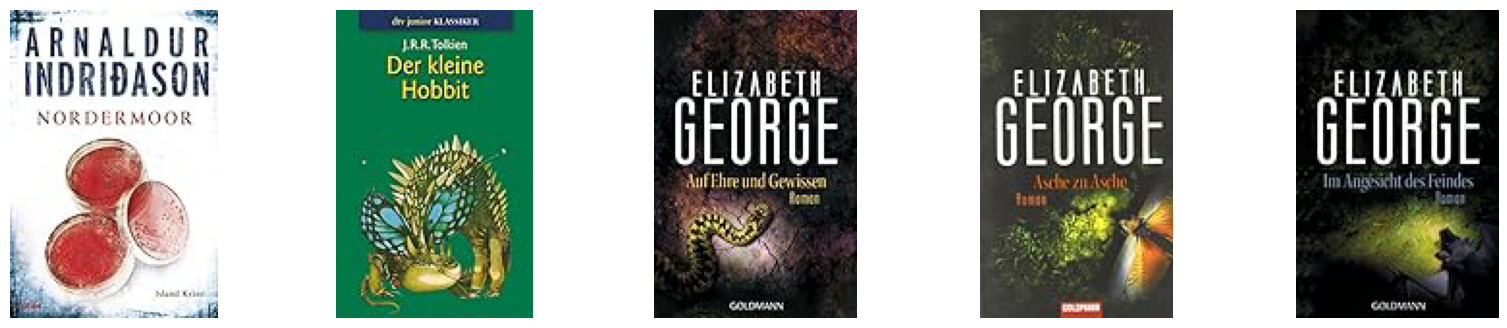

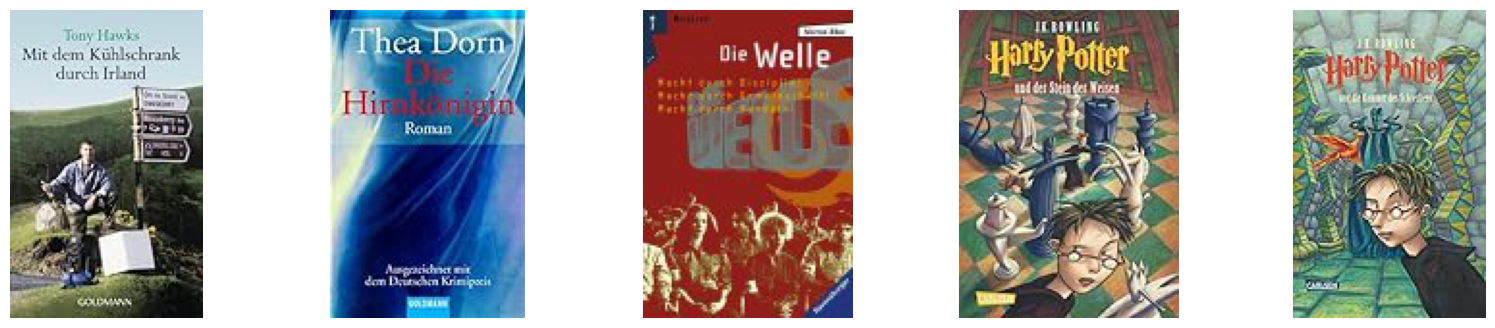

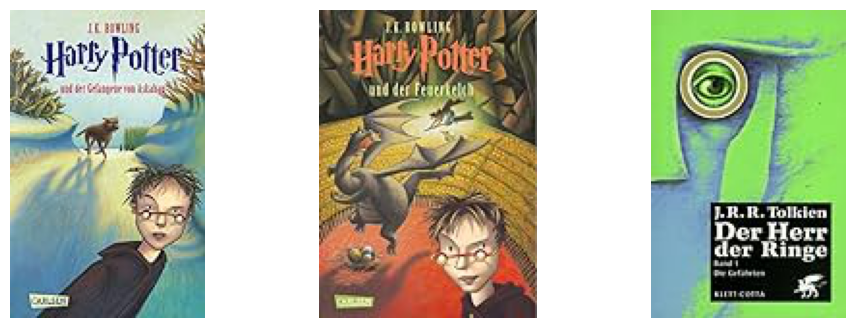

Такие рекомендации


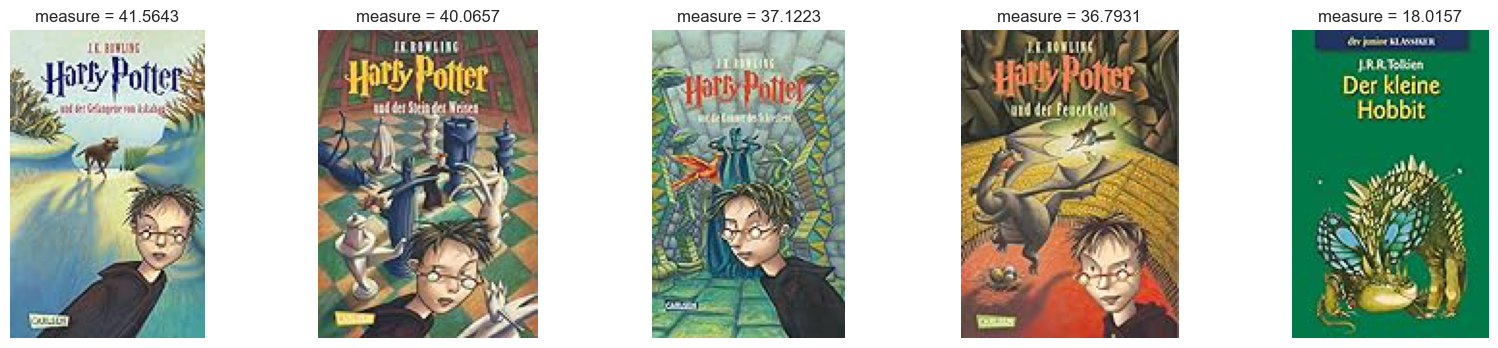

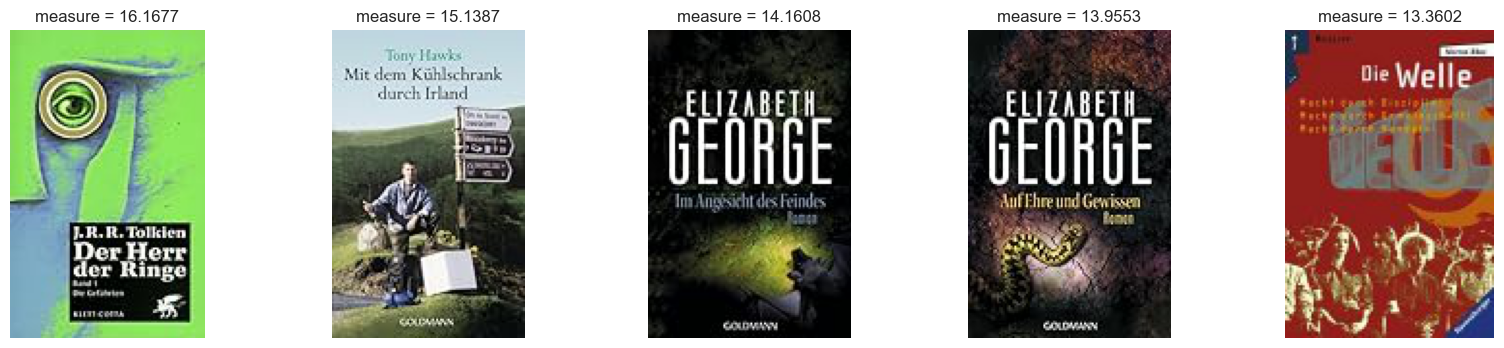

In [174]:
clb.user_based(10884)

Для таких товаров


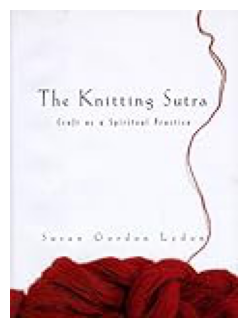

Такие рекомендации


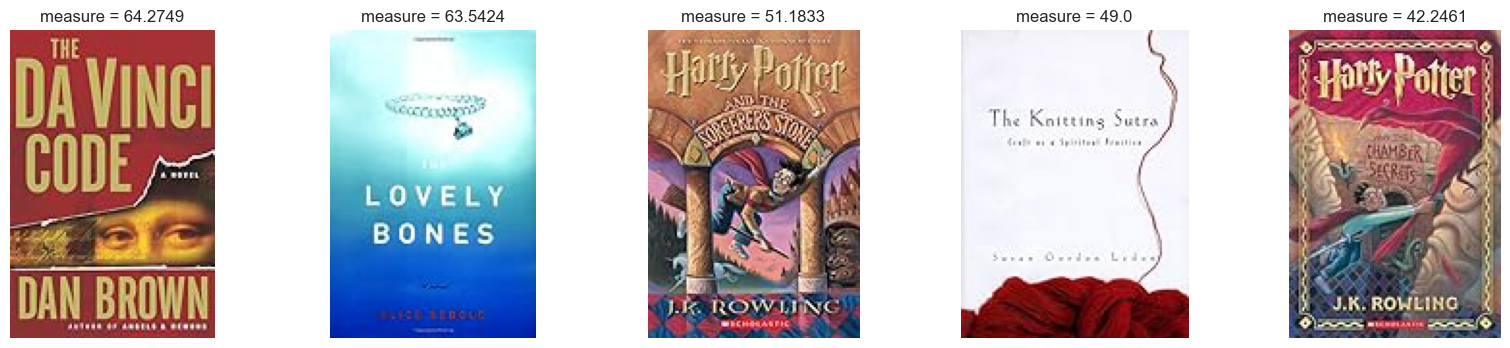

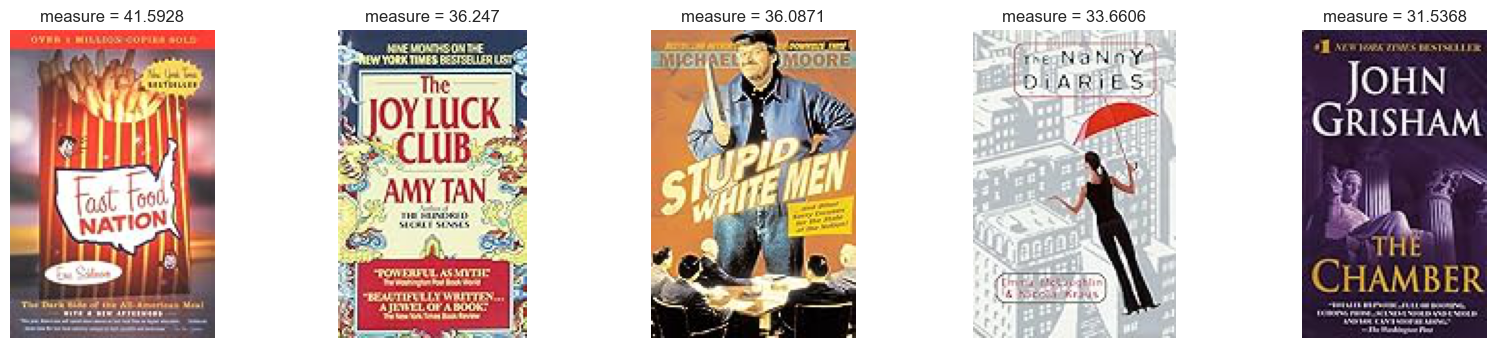

In [177]:
clb.item_based(650)